# Imports

In [128]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengo
from scipy import stats
import numpy as np
import pandas as pd
from KalmanFilters import LinearKF

# Testfall

$$\mathbf x = \begin{bmatrix}\theta \\ \dot{\theta}\end{bmatrix} = \begin{bmatrix}\theta \\ \omega\end{bmatrix} $$

In [129]:
dt = .04
dim_x = 2

init_state = np.array([0, 0.])

$$\dot{\theta} = \omega$$
$$\ddot{\theta} = \dot{\omega} = 0$$

$$\theta_{t+1} = \theta_t + \omega_t\Delta t$$
$$\omega_{t+1} = \omega_t$$

$$
F = \begin{bmatrix}
1 & dt \\
0 & 1
\end{bmatrix}
$$

In [130]:
F = np.array([[1.,  dt],
              [ 0,  1.]])

Q_var = 1.
Q = np.array([[.25*dt**4, .5*dt**3],
              [ .5*dt**3,    dt**2]]) * Q_var

init_cov_matrix = np.asarray([.05**2,     0
                                    , .5**2])

$$
z = \begin{bmatrix}
heading_{gyro} \\
heading_{magneto} \\
heading_{odometry} \\
heading_{vision} 
\end{bmatrix}
$$

In [131]:
dim_z = 4

$$
H = \begin{bmatrix}
\frac{180}{\pi} & 0 \\
\frac{180}{\pi} & 0 \\
\frac{180}{\pi} & 0 \\
\frac{180}{\pi} & 0 
\end{bmatrix}
$$

$$
R = \begin{bmatrix}
\sigma_{heading_{gyro}}^2 & 0 & 0 & 0 \\
0 & \sigma_{heading_{magneto}}^2 & 0 & 0 \\
0 & 0 & \sigma_{heading_{odometry}}^2 & 0 \\
0 & 0 & 0 & \sigma_{heading_{vision}}^2 
\end{bmatrix}
$$

In [132]:
H = np.zeros((dim_z, dim_x))
H[:, 0] = np.ones((dim_z,)) * (180 / np.pi)

# Messdaten

In [133]:
df = pd.read_csv('./heading_data.csv')
df.sample()

,head_gyro,head_magneto,head_odometry,head_vision
3850,263.482664,283.019,272.255488,270.095967


In [134]:
df = df[530:1041]
df = df.reset_index(drop=True)
zs = df.to_numpy()
n = len(zs)

In [135]:
gyro_linreg = stats.linregress(range(n), df['head_gyro'])
magneto_linreg = stats.linregress(range(n), df['head_magneto'])
odometry_linreg = stats.linregress(range(n), df['head_odometry'])
vision_linreg = stats.linregress(range(n), df['head_vision'])

In [136]:
def expected_value(x, linregresult):
    return linregresult.slope * x + linregresult.intercept

In [137]:
var_gyro = np.sum([(theta - expected_value(i, gyro_linreg))**2 for i, theta in enumerate(df['head_gyro'])]) / (n)
var_magneto = np.sum([(theta - expected_value(i, magneto_linreg))**2 for i, theta in enumerate(df['head_magneto'])]) / (n)
var_odometry = np.sum([(theta - expected_value(i, odometry_linreg))**2 for i, theta in enumerate(df['head_odometry'])]) / (n)
var_vision = np.sum([(theta - expected_value(i, vision_linreg))**2 for i, theta in enumerate(df['head_vision'])]) / (n)

R = np.diag([var_gyro, var_magneto, var_odometry, var_vision])

In [138]:
R

array([[0.7687074 , 0.        , 0.        , 0.        ],
       [0.        , 9.7481884 , 0.        , 0.        ],
       [0.        , 0.        , 0.48461317, 0.        ],
       [0.        , 0.        , 0.        , 1.96593463]])

# Klassisch

In [139]:
x = np.copy(init_state)
P = np.asarray([[.05**2,     0],
                [     0, .5**2]])

xs, cov = [], []

for z in zs:
    x = F @ x
    P = F @ P @ F.T + Q

    y = z - H @ x
    S = H @ P @ H.T + R
    K = P @ H.T @ np.linalg.inv(S)
    x += K @ y
    I_KH = np.eye(dim_x) - K @ H
    P = I_KH @ P @ I_KH.T + K @ R @ K.T

    xs.append(x)
    cov.append(P)

xs, cov = np.array(xs), np.array(cov)

(-0.25, 0.5)

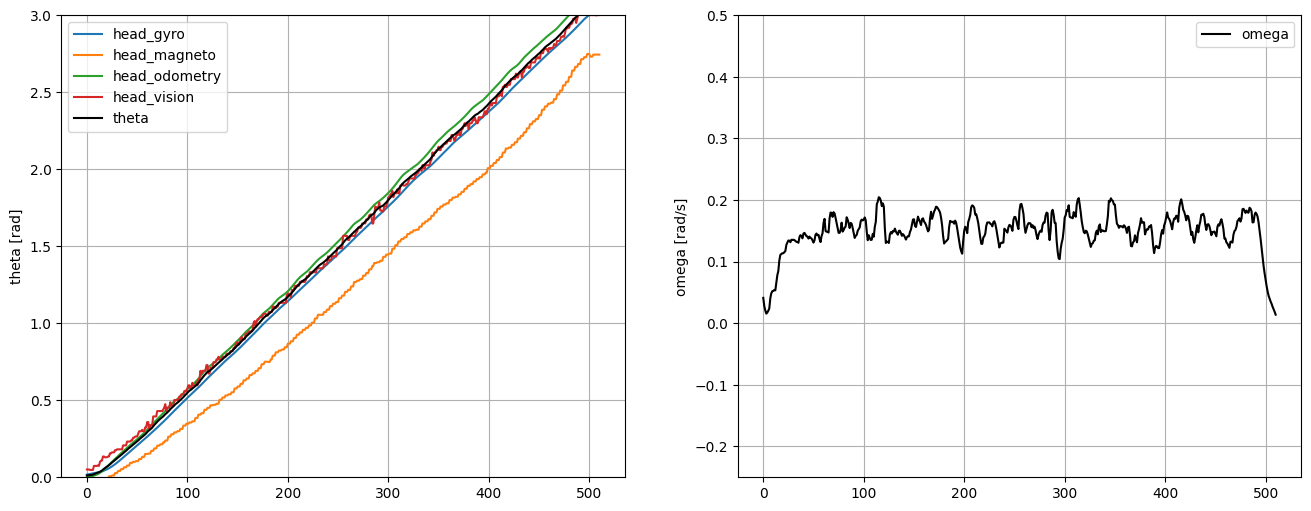

In [140]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(df['head_gyro'] * np.pi / 180, label='head_gyro')
plt.plot(df['head_magneto'] * np.pi / 180, label='head_magneto')
plt.plot(df['head_odometry'] * np.pi / 180, label='head_odometry')
plt.plot(df['head_vision'] * np.pi / 180, label='head_vision')
plt.plot(xs[:, 0], c="black", label="theta")
plt.ylabel("theta [rad]")
plt.grid()
plt.legend(loc="best")
plt.ylim(0, 3)

plt.subplot(1, 2, 2)
plt.plot(xs[:, 1], c="black", label="omega")
plt.ylabel("omega [rad/s]")
plt.grid()
plt.legend(loc="best")
plt.ylim(-.25, .5)

(0.0, 0.02)

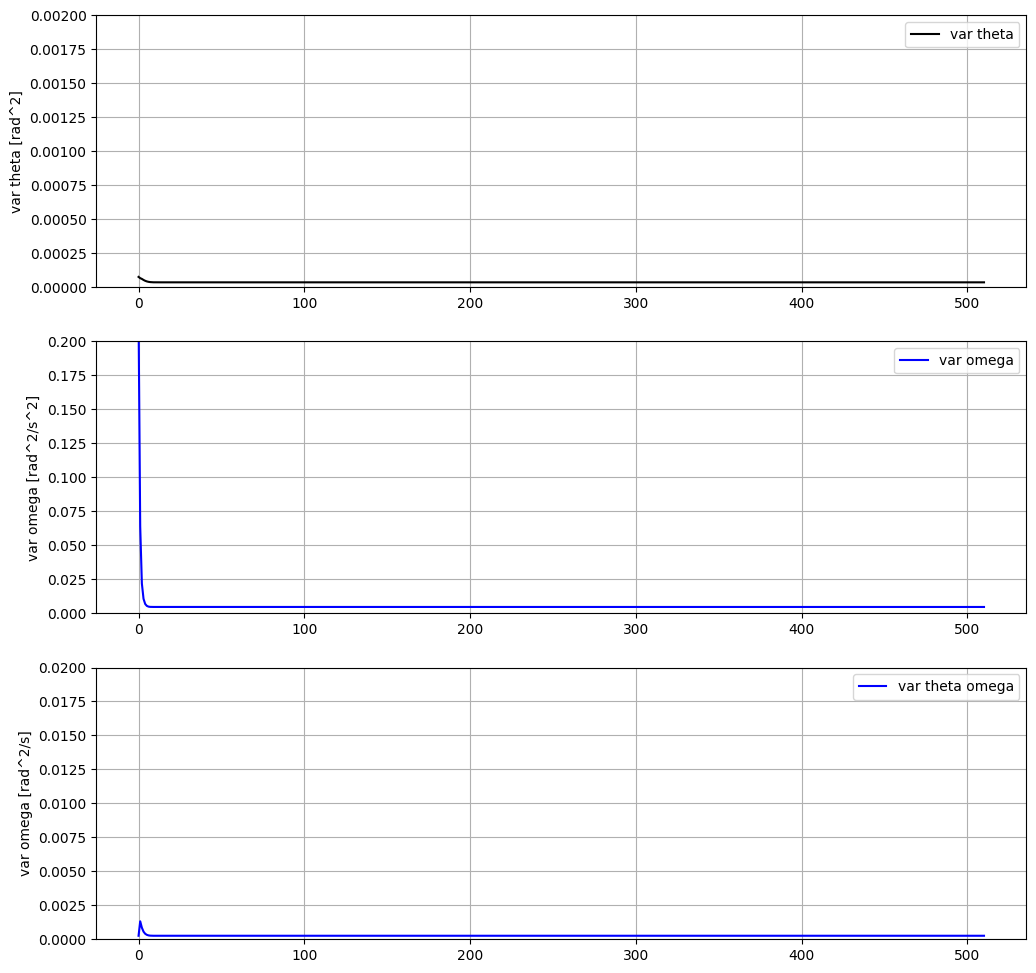

In [141]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(cov[:, 0, 0], c="black", label="var theta")
plt.ylabel("var theta [rad^2]")
plt.grid()
plt.legend(loc="best")
plt.ylim(0, .002)

plt.subplot(3, 1, 2)
plt.plot(cov[:, 1, 1], c="b", label="var omega")
plt.ylabel("var omega [rad^2/s^2]")
plt.grid()
plt.legend(loc="best")
plt.ylim(0, .2)

plt.subplot(3, 1, 3)
plt.plot(cov[:, 0, 1], c="b", label="var theta omega")
plt.ylabel("var omega [rad^2/s]")
plt.grid()
plt.legend(loc="best")
plt.ylim(0, .02)

# Nengo

In [142]:
kf = LinearKF(dim_x=dim_x, dim_z=dim_z, dt=dt, F=F, Q=Q, H=H, R=R)

In [143]:
kf.initial_x = init_state
kf.initial_P = init_cov_matrix
kf.simulation_runtime= 20.
kf.connection_synapse = .01
kf.x_radius = 3.5
kf.x_intercepts = nengo.dists.Uniform(-1.,1.)
kf.x_max_rates = nengo.dists.Uniform(400, 800)

In [144]:
probes = kf.build_model_for_measurements(zs).execute().get_probes()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/nengo/node.py:62: UserWarning: 'Node.size_out' is being overwritten with 'Node.size_in' since 'Node.output=None'
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

(-5.0, 5.0)

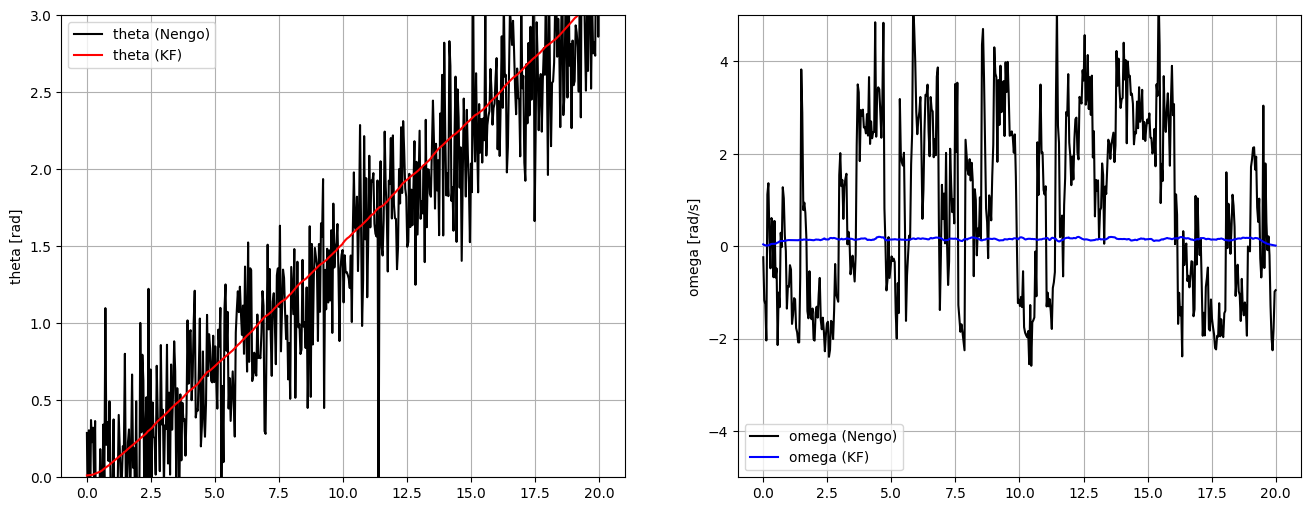

In [145]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(np.linspace(0,20.,500), probes['x'].T[0], c="black", label="theta (Nengo)")
plt.plot(np.linspace(0,20.,511), xs[:, 0], c="red", label="theta (KF)")
#plt.plot(np.linspace(0,20.,511), df['head_gyro'] * np.pi / 180, label='head_gyro')
#plt.plot(np.linspace(0,20.,511), df['head_magneto'] * np.pi / 180, label='head_magneto')
#plt.plot(np.linspace(0,20.,511), df['head_odometry'] * np.pi / 180, label='head_odometry')
#plt.plot(np.linspace(0,20.,511), df['head_vision'] * np.pi / 180, label='head_vision')
plt.ylabel("theta [rad]")
plt.grid()
plt.legend(loc="best")
plt.ylim(0, 3)

plt.subplot(1, 2, 2)
plt.plot(np.linspace(0,20,500), probes['x'].T[1], c="black", label="omega (Nengo)")
plt.plot(np.linspace(0,20,511), xs[:, 1], c="blue", label="omega (KF)")
plt.ylabel("omega [rad/s]")
plt.grid()
plt.legend(loc="best")
plt.ylim(-5, 5)

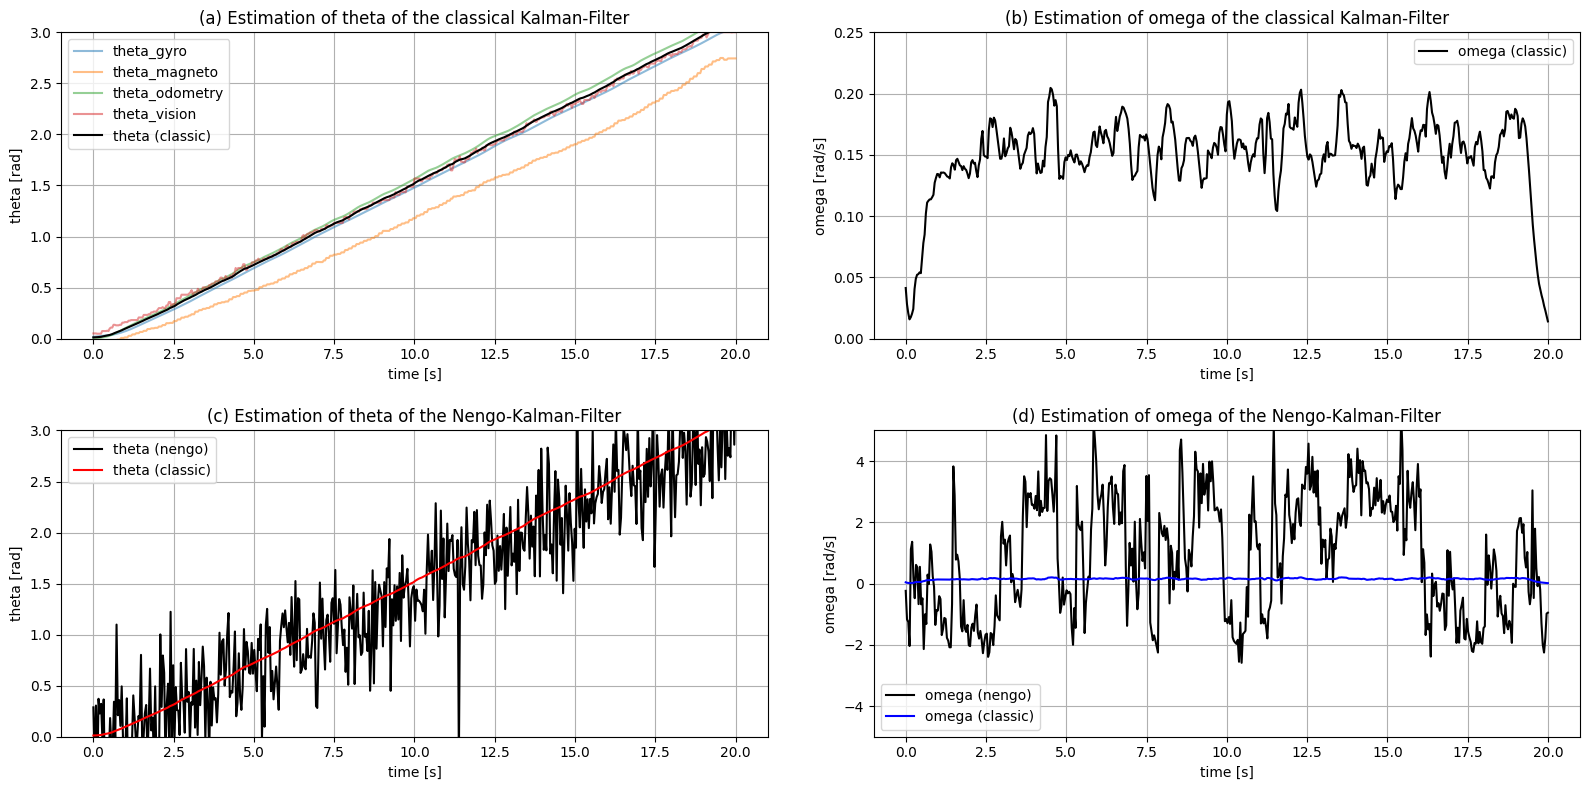

In [146]:
plt.figure(figsize=(16,8))
plt.subplot(2, 2, 1)
plt.title('(a) Estimation of theta of the classical Kalman-Filter')
plt.plot(np.linspace(0,20,511), df['head_gyro'] * np.pi / 180, label='theta_gyro', alpha=.5)
plt.plot(np.linspace(0,20,511), df['head_magneto'] * np.pi / 180, label='theta_magneto', alpha=.5)
plt.plot(np.linspace(0,20,511), df['head_odometry'] * np.pi / 180, label='theta_odometry', alpha=.5)
plt.plot(np.linspace(0,20,511), df['head_vision'] * np.pi / 180, label='theta_vision', alpha=.5)
plt.plot(np.linspace(0,20,511), xs[:, 0], c="black", label="theta (classic)")
plt.xlabel("time [s]")
plt.ylabel("theta [rad]")
plt.grid()
plt.legend(loc="best")
plt.ylim(0, 3)

plt.subplot(2, 2, 2)
plt.title('(b) Estimation of omega of the classical Kalman-Filter')
plt.plot(np.linspace(0,20,511), xs[:, 1], c="black", label="omega (classic)")
plt.xlabel("time [s]")
plt.ylabel("omega [rad/s]")
plt.grid()
plt.legend(loc="best")
plt.ylim(0, .25)

plt.subplot(2, 2, 3)
plt.title('(c) Estimation of theta of the Nengo-Kalman-Filter')
plt.plot(np.linspace(0,20.,500), probes['x'].T[0], c="black", label="theta (nengo)")
plt.plot(np.linspace(0,20.,511), xs[:, 0], c="red", label="theta (classic)")
plt.xlabel("time [s]")
plt.ylabel("theta [rad]")
plt.grid()
plt.legend(loc="best")
plt.ylim(0, 3)

plt.subplot(2, 2, 4)
plt.title('(d) Estimation of omega of the Nengo-Kalman-Filter')
plt.plot(np.linspace(0,20,500), probes['x'].T[1], c="black", label="omega (nengo)")
plt.plot(np.linspace(0,20,511), xs[:, 1], c="blue", label="omega (classic)")
plt.xlabel("time [s]")
plt.ylabel("omega [rad/s]")
plt.grid()
plt.legend(loc="best")
plt.ylim(-5, 5)

plt.tight_layout()
plt.subplots_adjust(wspace=.15, hspace=.3)
plt.show()